In [1]:
# Sample API
import flowx
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

Re   = 100.0
dt   = 0.01
tmax = 10.

# Define cell-centered variable names
center_vars = ['pres', 'divv', 'asol', 'eror']
face_vars   = ['velc', 'hvar', 'asol', 'eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 1.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}

# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=10.0, dt=0.01, Re=100.0)

In [3]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

while scalars.variable['time'] <= scalars.variable['tmax']:
    
    # Predictor Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

    # Divergence Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')
    
    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_jacobi(gridc, 'pres', 'divv',
                                                                       maxiter=2000, tol=1e-9)
    
    # Corrector Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)   

    scalars.advance()

------------ Time = 0.0 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.659530608424263e-05
Max, Min, U   : 2.0, -0.0636099254990361
Max, Min, V   : 0.15977932482079868, -0.15977932482079868
Max, Min, P   : 1.8058869165212974, -1.8058869165212974
Max, Min, DIV : 0.0015938339462575613, -0.0015938339462575613


------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 2.064619211142881e-07
Max, Min, U   : 2.0, -0.1353479630140306
Max, Min, V   : 0.30627573850763445, -0.3141633547834564
Max, Min, P   : 1.1784419404705688, -0.8703514369192809
Max, Min, DIV : 2.036048320164241e-05, -1.902794994101953e-05


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 6.963363741381347e-08
Max, Min, U   : 2.0, -0.15408079650284984
Max, Min, V   : 0.320051057133037, -0.3718028216546798
Max, Min, P   : 1.1785149582352892, -0.7890500357071678


------------ Time = 2.299999999999995 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.3466285347661043e-09
Max, Min, U   : 2.0, -0.23138473707492563
Max, Min, V   : 0.34589251170171614, -0.5054388531804402
Max, Min, P   : 1.2918452414010622, -0.6900334968492565
Max, Min, DIV : 1.6838506589067492e-07, -1.6763675892176796e-07


------------ Time = 2.399999999999993 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.2336046809737863e-09
Max, Min, U   : 2.0, -0.23230424386614743
Max, Min, V   : 0.3459373486355113, -0.5065731899526078
Max, Min, P   : 1.2931876600475576, -0.6897335124635396
Max, Min, DIV : 1.5354828164504397e-07, -1.5426095069598703e-07


------------ Time = 2.4999999999999907 ---------------
Number of poisson iterations    : 2000
Final poisson residual : 1.1336642808297602e-09
Max, Min, U   : 2.0, -0.23296913127681557
Max, Min, V   : 0.34597736893112635, -0.5075870871256203
Max, Min, P   : 1.2944302818714242, 

------------ Time = 4.599999999999946 ---------------
Number of poisson iterations    : 1297
Final poisson residual : 9.999170413332975e-10
Max, Min, U   : 2.0, -0.2376586134887429
Max, Min, V   : 0.34632939501858684, -0.5165227482010764
Max, Min, P   : 1.3079776648623411, -0.6867961743417311
Max, Min, DIV : 8.649898930457312e-08, -1.3575906414407118e-07


------------ Time = 4.699999999999944 ---------------
Number of poisson iterations    : 1269
Final poisson residual : 9.992783944922729e-10
Max, Min, U   : 2.0, -0.23773163518635815
Max, Min, V   : 0.3463358783062283, -0.5166883899818739
Max, Min, P   : 1.3082902786756703, -0.6867365366594382
Max, Min, DIV : 8.40607423668871e-08, -1.364294450125099e-07


------------ Time = 4.799999999999942 ---------------
Number of poisson iterations    : 1241
Final poisson residual : 9.99009617391765e-10
Max, Min, U   : 2.0, -0.23779218978512745
Max, Min, V   : 0.34634194885866804, -0.516843633998875
Max, Min, P   : 1.3085858628461966, -0.68668008

------------ Time = 6.899999999999897 ---------------
Number of poisson iterations    : 735
Final poisson residual : 9.986558978713984e-10
Max, Min, U   : 2.0, -0.2391628217265446
Max, Min, V   : 0.3464110811885108, -0.5186260585818571
Max, Min, P   : 1.3121635698036012, -0.6859905820734147
Max, Min, DIV : 8.552079777679467e-08, -1.63547071133259e-07


------------ Time = 6.999999999999895 ---------------
Number of poisson iterations    : 715
Final poisson residual : 9.997740515250948e-10
Max, Min, U   : 2.0, -0.23920286883871178
Max, Min, V   : 0.3464126969465027, -0.5186681440711229
Max, Min, P   : 1.3122521680787653, -0.6859733084560363
Max, Min, DIV : 8.513521548847436e-08, -1.6500554671618553e-07


------------ Time = 7.099999999999893 ---------------
Number of poisson iterations    : 696
Final poisson residual : 9.994812292334346e-10
Max, Min, U   : 2.0, -0.23924026361793338
Max, Min, V   : 0.34641422334760863, -0.5187079250932255
Max, Min, P   : 1.3123360884450923, -0.6859569323

------------ Time = 9.199999999999848 ---------------
Number of poisson iterations    : 391
Final poisson residual : 9.996538767296538e-10
Max, Min, U   : 2.0, -0.23965692175456957
Max, Min, V   : 0.3464325422045425, -0.5191872588023264
Max, Min, P   : 1.3133602991210707, -0.6857554760987739
Max, Min, DIV : 9.311812376733286e-08, -1.6533299322489536e-07


------------ Time = 9.299999999999846 ---------------
Number of poisson iterations    : 381
Final poisson residual : 9.966449181594954e-10
Max, Min, U   : 2.0, -0.23966641988279416
Max, Min, V   : 0.3464329910779808, -0.5191990522316037
Max, Min, P   : 1.313385794361284, -0.6857504102976899
Max, Min, DIV : 9.405591361311139e-08, -1.637571375228894e-07


------------ Time = 9.399999999999844 ---------------
Number of poisson iterations    : 370
Final poisson residual : 9.969320773057468e-10
Max, Min, U   : 2.0, -0.23967538173627384
Max, Min, V   : 0.34643341596737404, -0.5192102184996402
Max, Min, P   : 1.3134099437408582, -0.685745608

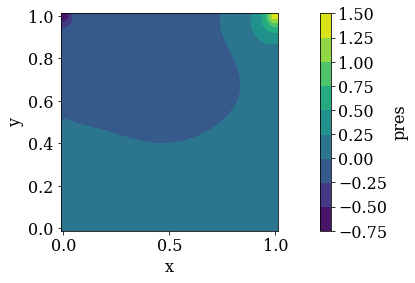

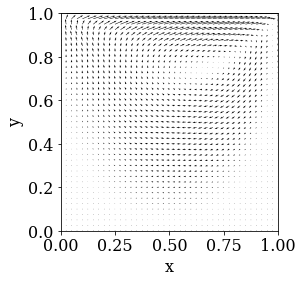

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_vector(gridx,gridy,'velc')